<a href="https://colab.research.google.com/github/Shravanya178/MLDL_EXPS/blob/main/MLDL_EXP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,accuracy_score, confusion_matrix, classification_report

In [ ]:
df = pd.read_csv("CEEW - IRES Data.csv", low_memory=False)
print("Dataset shape:", df.shape)

Dataset shape: (14851, 517)


In [ ]:
df_svm = df.copy()

df_svm = df_svm[df_svm['q609_prepaid_meter_int'].isin([0, 1])]

df_svm['Prepaid_Interest'] = np.where(
    df_svm['q609_prepaid_meter_int'] == 1, 1, 0
)

print("Target Distribution:")
print(df_svm['Prepaid_Interest'].value_counts())

Target Distribution:
Prepaid_Interest
0    9533
1    2069
Name: count, dtype: int64


In [ ]:
predictors = [
    'asset_index_1',
    'q208_priminc_earner_edu',
    'q202_resp_age',
    'q213_no_members',
    'q302_grid_hrs_no',
    'q308_grid_voltage_low_app',
    'q326_satis_electricity',
    'q314_a_online_pay_ever_yn',
    'q401_bee_star_label_heard_yn'
]

df_model = df_svm[predictors + ['Prepaid_Interest']].dropna()

print("Final modeling shape:", df_model.shape)
print("Final class distribution:")
print(df_model['Prepaid_Interest'].value_counts())

Final modeling shape: (7186, 10)
Final class distribution:
Prepaid_Interest
0    5759
1    1427
Name: count, dtype: int64


In [ ]:
X = df_model[predictors]
y = df_model['Prepaid_Interest']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_s, y_train)

y_prob = log_reg.predict_proba(X_test_s)[:,1]

print("Baseline Logistic AUC:", roc_auc_score(y_test, y_prob))

Baseline Logistic AUC: 0.6091989607614607


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
svm = SVC(
    kernel='rbf',
    probability=True,
    class_weight='balanced',
    random_state=42
)

param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 0.1]
}

grid_search = GridSearchCV(
    svm,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_s, y_train)

GridSearchCV(cv=5,
             estimator=SVC(class_weight='balanced', probability=True,
                           random_state=42),
             n_jobs=-1, param_grid={'C': [1, 10], 'gamma': ['scale', 0.1]},
             scoring='roc_auc')

In [24]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation AUC:", grid_search.best_score_)

Best Parameters: {'C': 1, 'gamma': 'scale'}
Best Cross-Validation AUC: 0.6411147268515057


In [25]:
best_svm = grid_search.best_estimator_

y_pred = best_svm.predict(X_test_s)
y_prob = best_svm.predict_proba(X_test_s)[:, 1]

In [26]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    balanced_accuracy_score
)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))

Test Accuracy: 0.655076495132128
Balanced Accuracy: 0.6165015540015539

Confusion Matrix:
[[784 368]
 [128 158]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76      1152
           1       0.30      0.55      0.39       286

    accuracy                           0.66      1438
   macro avg       0.58      0.62      0.57      1438
weighted avg       0.75      0.66      0.69      1438

Test ROC-AUC: 0.642321654040404


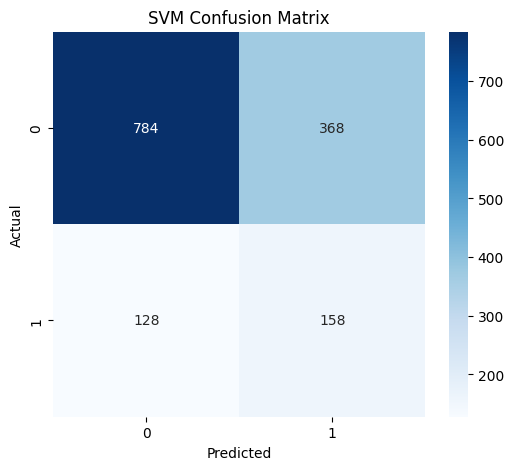

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

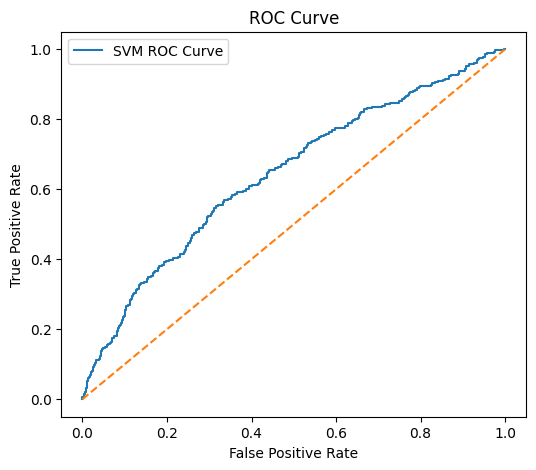

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="SVM ROC Curve")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

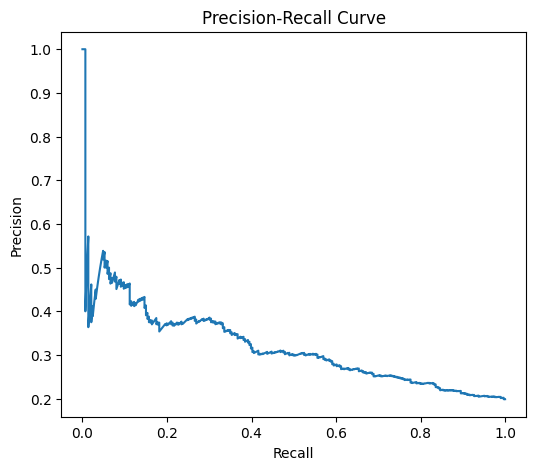

Average Precision Score: 0.320117805604908


In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

print("Average Precision Score:", average_precision_score(y_test, y_prob))

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score

# -------- Decision Tree --------
dt = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
)

dt.fit(X_train_s, y_train)

dt_pred = dt.predict(X_test_s)
dt_prob = dt.predict_proba(X_test_s)[:,1]

dt_acc = accuracy_score(y_test, dt_pred)
dt_auc = roc_auc_score(y_test, dt_prob)
dt_bal_acc = balanced_accuracy_score(y_test, dt_pred)


# -------- Random Forest --------
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train_s, y_train)

rf_pred = rf.predict(X_test_s)
rf_prob = rf.predict_proba(X_test_s)[:,1]

rf_acc = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_prob)
rf_bal_acc = balanced_accuracy_score(y_test, rf_pred)


# -------- KNN --------
knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X_train_s, y_train)

knn_pred = knn.predict(X_test_s)
knn_prob = knn.predict_proba(X_test_s)[:,1]

knn_acc = accuracy_score(y_test, knn_pred)
knn_auc = roc_auc_score(y_test, knn_prob)
knn_bal_acc = balanced_accuracy_score(y_test, knn_pred)


# -------- SVM (already trained) --------
svm_acc = accuracy_score(y_test, y_pred)
svm_auc = roc_auc_score(y_test, y_prob)
svm_bal_acc = balanced_accuracy_score(y_test, y_pred)


print("Decision Tree AUC:", dt_auc)
print("Random Forest AUC:", rf_auc)
print("KNN AUC:", knn_auc)
print("SVM AUC:", svm_auc)

Decision Tree AUC: 0.5893095619658121
Random Forest AUC: 0.6729388233294484
KNN AUC: 0.6019009202602952
SVM AUC: 0.642321654040404


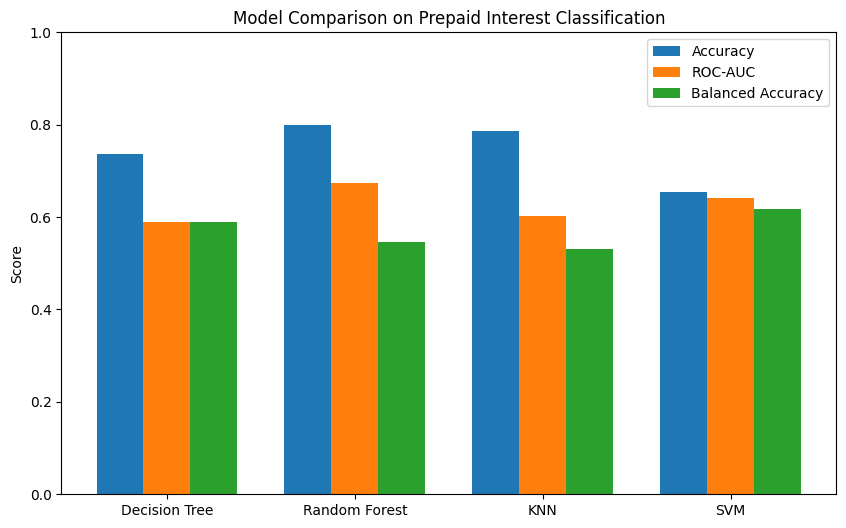

In [32]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Decision Tree', 'Random Forest', 'KNN', 'SVM']

accuracy = [dt_acc, rf_acc, knn_acc, svm_acc]
roc_auc = [dt_auc, rf_auc, knn_auc, svm_auc]
balanced_acc = [dt_bal_acc, rf_bal_acc, knn_bal_acc, svm_bal_acc]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10,6))

plt.bar(x - width, accuracy, width, label='Accuracy')
plt.bar(x, roc_auc, width, label='ROC-AUC')
plt.bar(x + width, balanced_acc, width, label='Balanced Accuracy')

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Model Comparison on Prepaid Interest Classification")
plt.ylim(0,1)
plt.legend()
plt.show()